# Supplier Ranking Methods (Multi-criteria Decision-Making or MCDM)
Prepared by: Nickolas Freeman, Ph.D.

This notebook presents techniques for ranking suppliers. These techniques are useful for identifying a subset of candidate suppliers from a potentially large set of available suppliers. The difficulty in such selection tasks is that oftentimes there are several competing criteria that we would like to use for evaluation. For example, buying firms care about both cost and quality. However, it may be impossible to find a supplier that offers exceptional performance with respect to both criteria because the two criteria may be negatively correlated (e.g., the supplier is able to offer products at a lower cost because they do not enforce very stringent quality controls). 

Another complicating factor is that it is common for a buying firm to be interested in both quantitative and qualitative criteria. However, comparing scores for quantitative and qualitative aspects is difficult. For example, how much of a cost increase is improved technical support or sustainability efforts worth? The approaches we consider in this notebook assign a quantitative score to subjective criteria and employ relatively simple weighting techniques to determine overall scores. A hyperlinked table of contents follows.


# Table of Contents
<a id="Table_of_Contents"> </a>
1. [Data Preparation](#Data_Preparation)<br>
    1.1 [Ensuring Consistent Ranking Orders](#Consistent_Rank_Orders)<br>
    1.2 [Data Normalization](#Data_Normalization)<br>
    1.3 [Weight Normalization](#Weight_Normalization)<br>
2. [Technique 1: Weighted Sum Method](#Weighted_Sum_Method)<br>
3. [Technique 2: Weighted Product Method](#Weighted_Product_Method)<br>
4. [Technique 3: TOPSIS Method](#TOPSIS_Method)<br>
5. [Weight Determination via Analytic Hierarchy Process (AHP)](#Weights_via_AHP)<br>
6. [Ensemble Methods](#Ensemble_Methods)<br>
    
The following code block imports some packages that we will use.

In [1]:
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import numpy as np

import matplotlib.pyplot as plt

from ipywidgets import interact

Throughout this notebook, we will be using a dataset that includes scores for 25 suppliers on several qualitative and quantitative factors. The following code block reads in the data, which is in a .csv file named "Supplier_Data.csv." The `Warranty Terms`, `Payment Terms`, `Technical Support`, `Sustainability Efforts`, and `Financial Stability` columns include subjective scores for each supplier that range from 1-10, with 1 being the lowest rating and 10 being the highest rating. The `Unit Cost` column specifies the unit cost charged by the supplier. The `Lead Time (Days)` column specifies the supplier's average lead time in days. The `On Time Delivery` column specifies the supplier's on-time delivery performance as a propotion. These last two columns may be based on quotes, historical transactions provided to the buying firm, or references. 

[Back to Table of Contents](#Table_of_Contents)<br>

In [2]:
supplier_data = pd.read_csv('https://nkfreeman.people.ua.edu/uploads/1/2/3/6/123664668/supplier_data.csv')
supplier_data.head(5)

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,Unit Cost,Lead Time (Days),On Time Delivery
0,1,2,3,8,3,8,1.05,8,0.75
1,2,7,2,4,6,4,1.21,13,0.83
2,3,9,1,3,9,5,1.22,12,0.91
3,4,5,5,6,7,9,1.01,9,0.72
4,5,5,7,2,9,4,1.03,7,0.97


# Data Preparation
<a id="Data_Preparation"> </a>

Before proceeding with our supplier rankings, we must prepare the data for the analysis. In particular, there are two issues with the raw data.
1. The interpretation of the scores with respect to order is not consistent. In particular, higher values are more attractive than lower values for `Warranty Terms`, `Payment Terms`, `Technical Support`, `Sustainability Efforts`, `Financial Stability`, and `On Time Delivery`. However, lower values are more attractive than higher values for `Unit Cost` and `Lead Time (Days)`. 
2. The scale for the various columns differ. For example, the `Warranty Terms` scores vary from 1 to 10 while the `On Time Delivery` scores vary from 0 to 1. The techniques we will use from ranking are all based on computing some weighted function of the supplier attributes. Thus, any inconsistencies in scale will result in certain attributes being over- or under-weighted in the resulting ranking.

To demonstrate the difference in scales suggested in point 2, the following code block uses the Pandas `describe()` method to show various statistics for each column in the `supplier_data` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [3]:
supplier_data.describe()

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,Unit Cost,Lead Time (Days),On Time Delivery
count,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00
mean,13.00,6.08,4.68,5.60,6.12,5.76,1.14,9.20,0.86
std,7.36,2.78,2.85,2.80,2.26,2.79,0.09,4.00,0.10
min,1.00,2.00,1.00,1.00,2.00,1.00,1.01,2.00,0.71
25%,7.00,3.00,2.00,3.00,5.00,3.00,1.05,6.00,0.79
50%,13.00,6.00,4.00,6.00,6.00,6.00,1.15,9.00,0.86
75%,19.00,9.00,7.00,8.00,8.00,8.00,1.22,13.00,0.95
max,25.00,10.00,10.00,10.00,10.00,10.00,1.28,15.00,1.00


# Ensuring Consistent Ranking Orders
<a id="Consistent_Rank_Orders"> </a>

In this section we will address the inconsistencies in score interpretation. To do this, we will ensure that all attribute scores are given in a *higher is better* format. The following code block defines a function that will perform this conversion.

[Back to Table of Contents](#Table_of_Contents)<br>

In [4]:
def convert_to_higher_is_better(data, columns, conversion_type = 'absolute', drop_columns = False):
    """
    Converts values provided in a "lower is better" format to a "higher is better" format

    Arguments
    ----------
    data: a pandas DataFrame object that contains the specified columns
    
    columns: a list object that includes the name of the columns to convert
    
    conversion_type : a string or list of strings specifying the type of 
        conversion to perform
        - 'absolute' converts based on absolute scale (default)
        - 'relative' converts based on relative scale
    
    drop_columns: True or False to indicate whether or not original columns
        should be dropped from the returned DataFrame
        
    Returns
    ------
    temp_df: a copy of the passed DataFrame with the conversions performed
    """
    import numpy as np
    import pandas as pd
    
    temp_df = data.copy()
    
    error_flag = 0
    if isinstance(conversion_type, list): 
        if (len(conversion_type) == len(columns)):    
            for i in range(len(columns)):
                if conversion_type[i] == 'absolute':
                    new_column = columns[i] +' (absolute HIB)'
                    max_entry = temp_df[columns[i]].max()
                    min_entry = temp_df[columns[i]].min()
                    temp_df[new_column] = (max_entry - temp_df[columns[i]]) + min_entry

                elif conversion_type[i] == 'relative':
                    new_column = columns[i] +' (relative HIB)'
                    min_entry = temp_df[columns[i]].min()
                    max_entry = temp_df[columns[i]].max()
                    temp_df[new_column] = (max_entry - temp_df[columns[i]])/(max_entry-min_entry)

                else:
                    print('You did not enter a valid type, so no changes were made')  
                    error_flag = 1
                
        else:
            print('The length of the specified list of columns and conversion types do not match. No changes were made.')
            error_flag = 1
    else:
        if conversion_type is 'absolute':
            for column in columns:
                new_column = column +' (absolute HIB)'
                max_entry = temp_df[column].max()
                min_entry = temp_df[column].min()
                temp_df[new_column] = (max_entry - temp_df[column]) + min_entry

        elif conversion_type is 'relative':
            for column in columns:
                new_column = column + '(relative HIB)'
                min_entry = temp_df[column].min()
                max_entry = temp_df[column].max()
                temp_df[new_column] = (max_entry - temp_df[column])/(max_entry-min_entry)

        else:
            print('You did not enter a valid type, so no changes were made') 
            error_flag = 1
        
    if drop_columns & (error_flag == 0):
        temp_df = temp_df.drop(columns = columns)
    
        
    return temp_df    

The following code block demonstrates the use of our function. Note the difference in the *absolute* and *relative* conversions for the unit cost column. In particular, when using the *absolute* conversion, the lowest and highest costs are flipped, and all cost in between the highest and lowest are reassigned accordingly. On the other hand, the *relative* conversion assigns the highest cost a value of 0.0, the lowest cost a value of 1.0, and all other costs are assigned values between 0.0 and 1.0 according to their distance from the minimum and maximum values.

[Back to Table of Contents](#Table_of_Contents)<br>

In [5]:
convert_to_higher_is_better(supplier_data,
                            ['Unit Cost', 'Unit Cost', 'Lead Time (Days)'],
                            ['absolute', 'relative', 'relative'], 
                            drop_columns = False)

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,Unit Cost,Lead Time (Days),On Time Delivery,Unit Cost (absolute HIB),Unit Cost (relative HIB),Lead Time (Days) (relative HIB)
0,1,2,3,8,3,8,1.05,8,0.75,1.24,0.85,0.54
1,2,7,2,4,6,4,1.21,13,0.83,1.08,0.26,0.15
2,3,9,1,3,9,5,1.22,12,0.91,1.07,0.22,0.23
3,4,5,5,6,7,9,1.01,9,0.72,1.28,1.00,0.46
4,5,5,7,2,9,4,1.03,7,0.97,1.26,0.93,0.62
5,6,8,7,3,7,6,1.18,14,0.83,1.11,0.37,0.08
6,7,9,6,3,7,3,1.13,6,1.00,1.16,0.56,0.69
7,8,9,4,1,9,3,1.04,15,0.81,1.25,0.89,0.00
8,9,8,2,2,9,9,1.02,8,0.95,1.27,0.96,0.54
9,10,2,8,4,6,6,1.10,11,0.98,1.19,0.67,0.31


The following code block uses our function to overwrite the `supplier_data` object. We use an absolute conversion for the `Unit Cost` column and a *relative* conversion for the `Lead Time (Days)` column.

[Back to Table of Contents](#Table_of_Contents)<br>

In [6]:
supplier_data = convert_to_higher_is_better(supplier_data,
                                            ['Unit Cost', 'Lead Time (Days)'], 
                                            ['absolute', 'relative'], 
                                            drop_columns = True)

# Data Normalization
<a id="Data_Normalization"> </a>

We will now address the scale differences that we observed in the various columns. The following code block defines a function for this purpose.

[Back to Table of Contents](#Table_of_Contents)<br>

In [7]:
def normalize_columns(data, columns, norm_type = 'divide_by_max'):
    """
    Normalizes values in specified columns of a pandas dataframe

    Arguments
    ----------
    data: a pandas DataFrame object that contains the specified columns
    
    columns: a list object that includes the columns to normalize
    
    norm_type : a string specifying the type of normalization to perform
        - 'divide_by_max' divides all values by the maximum value
        - 'range_norm' divides all values (+ the min) by the range of values in the column
        - 'z_norm' computes a z-score based on the mean and standard deviation of values
        - 'divide_by_sum' divides all values by the sum of the values
        - 'vector' dives all values by the square root of the sum of the squares of all values

    Returns
    ------
    temp_df: a copy of the passed dataframe with the normalizations performed

    """   
    import numpy as np
    import pandas as pd
    
    temp_df = data.copy()
    
    for column in columns:
        if norm_type is 'divide_by_max':
            max_entry = temp_df[column].max()
            temp_df[column] = temp_df[column]/max_entry
        
        elif norm_type is 'range_norm':
            min_entry = temp_df[column].min()
            max_entry = temp_df[column].max()
            temp_df[column] = (temp_df[column]-min_entry)/(max_entry - min_entry)
        
        elif norm_type is 'z_norm':
            mean = temp_df[column].mean()
            sd = temp_df[column].std()
            temp_df[column] = (temp_df[column]-mean)/sd
        
        elif norm_type is 'divide_by_sum':
            temp_df[column] = temp_df[column]/temp_df[column].sum()
            
        elif norm_type is 'vector':
            values = temp_df[column].values
            values_squared = values**2
            vector_norm = values/np.sqrt(np.sum(values_squared))
            temp_df[column] = vector_norm
        
        else:
            print('You did not enter a valid type, so no changes were made')
        
    return temp_df

To the following code block provides an interactive visualization that demonstrates that there is essentially no difference with respect to the relative difference between values with the various normalization methods that our `normalize_columns` function includes.

[Back to Table of Contents](#Table_of_Contents)<br>

In [8]:
norm_methods = ['divide_by_max', 
                'range_norm', 
                'z_norm', 
                'divide_by_sum', 
                'vector']

from ipywidgets import interact

@interact(norm_method = norm_methods)

def interactive_spend_analysis(norm_method = norm_methods[0]):

    
    data_copy = supplier_data.copy()
    data_copy = data_copy.sort_values(by = 'Warranty Terms')

    original_values = data_copy['Warranty Terms'].values

    normalized_values = normalize_columns(data_copy, 
                                          ['Warranty Terms'], 
                                          norm_type = norm_method )['Warranty Terms'].values
    
    fig, ax = plt.subplots(figsize = (10,6))
    
    ax.plot(original_values)
    ax.set_ylabel('Original Values', color='k') 
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Normalized Values', color='b')
    ax2.plot(normalized_values, color= 'b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    plt.show()

interactive(children=(Dropdown(description='norm_method', options=('divide_by_max', 'range_norm', 'z_norm', 'd…

The following code block defines the attribute columns as the `columns_to_normalize`, normalizes the `supplier_data` object using the default `divide_by_max` option, and prints the first five rows of the normalized `supplier_data` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [9]:
columns_to_normalize = supplier_data.columns[1:]

supplier_data = normalize_columns(supplier_data, 
                                  columns_to_normalize)

supplier_data.head()

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,On Time Delivery,Unit Cost (absolute HIB),Lead Time (Days) (relative HIB)
0,1,0.20,0.30,0.80,0.30,0.80,0.75,0.97,0.54
1,2,0.70,0.20,0.40,0.60,0.40,0.83,0.84,0.15
2,3,0.90,0.10,0.30,0.90,0.50,0.91,0.84,0.23
3,4,0.50,0.50,0.60,0.70,0.90,0.72,1.00,0.46
4,5,0.50,0.70,0.20,0.90,0.40,0.97,0.98,0.62


# Weight Normalization
<a id="Weight_Normalization"> </a>

Now that our data is prepared, we will turn our attention to the weights. As mentioned before, the supplier selection methods that we will look as all rely on a weighted function of the attributes for ranking. It is common practice for the weights used for these analysis to also be normalized. The following code block defines a simple function for weight normalization.

[Back to Table of Contents](#Table_of_Contents)<br>

In [10]:
def normalize_array(array, norm_type = 'divide_by_sum'):
    """
    Normalizes a provided weight array so that the sum equals 1

    Arguments
    ----------
    array : a NumPy array containing the numbers to normalize
    
    norm_type : a string specifying the type of normalization to perform
        - 'divide_by_max' divides all values by the maximum value
        - 'divide_by_sum' divides all values by the sum of the values

    Returns
    ------
    temp_array: a copy of the passed array with the normalizations performed

    """   
    
    import numpy as np
    import pandas as pd
    
    temp_array = array.copy()
    
    if norm_type is 'divide_by_max':
        temp_array = temp_array/temp_array.max()

    elif norm_type is 'divide_by_sum':
        temp_array = temp_array/temp_array.sum()
        
    else:
        print('You did not enter a valid type, so no changes were made')
    
    return temp_array

Since we have eight attributes in our `supplier_data` object, we will use a weight array that includes eight weightes. The following code block defines the `weights` array that we will use, normalizes the array, and prints the normalized array.

[Back to Table of Contents](#Table_of_Contents)<br>

In [11]:
weights = np.array([ 3,  8,  2,  5,  8, 10,  7,  2])

weights = normalize_array(weights)

weights

array([0.06666667, 0.17777778, 0.04444444, 0.11111111, 0.17777778,
       0.22222222, 0.15555556, 0.04444444])

# Technique 1: Weighted Sum Method
<a id="Weighted_Sum_Method"> </a>

The weighted sum approach we are going to look at is arguably the best known and simplest method for evaluating a set of alternatives according to a number of criteria. 

>[The weighted sum method of supplier rating determines a] weighted point [estimate for each supplier], which consider attributes that are weighted by the buyer. The weight for each attribute is then multiplied by the performance score that is assigned. Finally, these products are totaled to determine final rating for each supplier. Typically this system is designed to utilize quantitative measurements. The advantages of the weighted point method include the ability for the organization to include numerous evaluation factors and assign them weights according to the organization’s needs. The subjective factors on the evaluation are minimized. The major limitation of this approach is that it is difficult to effectively take qualitative evaluation criteria into consideration.
>
> - Khaled, A.A., Paul, S. K., Ripon Kumar Chakrabortty, M., & Ayuby, S. (2011). Selection of suppliers through different multi-criteria decision making techniques. Global Journal of Management and Business Research, 11(4).

Assume that we want to evaluate $m$ alternatives (suppliers) on $n$ criteria and that higher values of all criteria are better. Let $w_{j}$ denote the relative weight of criterion $C_{j}$ and $a_{ij}$ denote the score of alternative $A_{i}$ when in terms of criterion $C_{j}$. Using the described notation, the weighted sum score for alternative $A_{i}$ is given by:

$$\sum_{j=1}^{n}w_{j}a_{ij},\mbox{ for }i=1,2,3,\ldots,m.$$

The following code block simply refreshes our data and performs the previously described data preparation steps.

[Back to Table of Contents](#Table_of_Contents)<br>

In [12]:
supplier_data = pd.read_csv('https://nkfreeman.people.ua.edu/uploads/1/2/3/6/123664668/supplier_data.csv')

supplier_data = convert_to_higher_is_better(supplier_data,
                                            ['Unit Cost', 'Lead Time (Days)'], 
                                            ['absolute', 'relative'], 
                                            drop_columns = True)

columns_to_normalize = supplier_data.columns[1:]

supplier_data = normalize_columns(supplier_data,
                                  columns_to_normalize)

weights = np.array([ 3,  8,  2,  5,  8, 10,  7,  2])

weights = normalize_array(weights)

The following code block shows how we may perform operations on our `supplier_data` `DataFrame` object to computed the weighted sum score for all suppliers. 

[Back to Table of Contents](#Table_of_Contents)<br>

In [13]:
supplier_data['Weighted Sum'] = 0
for i in range(len(columns_to_normalize)):
    supplier_data['Weighted Sum'] += supplier_data[columns_to_normalize[i]]*weights[i]
    
supplier_data

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,On Time Delivery,Unit Cost (absolute HIB),Lead Time (Days) (relative HIB),Weighted Sum
0,1,0.20,0.30,0.80,0.30,0.80,0.75,0.97,0.54,0.62
1,2,0.70,0.20,0.40,0.60,0.40,0.83,0.84,0.15,0.56
2,3,0.90,0.10,0.30,0.90,0.50,0.91,0.84,0.23,0.62
3,4,0.50,0.50,0.60,0.70,0.90,0.72,1.00,0.46,0.72
4,5,0.50,0.70,0.20,0.90,0.40,0.97,0.98,0.62,0.73
5,6,0.80,0.70,0.30,0.70,0.60,0.83,0.87,0.08,0.70
6,7,0.90,0.60,0.30,0.70,0.30,1.00,0.91,0.69,0.71
7,8,0.90,0.40,0.10,0.90,0.30,0.81,0.98,0.00,0.62
8,9,0.80,0.20,0.20,0.90,0.90,0.95,0.99,0.54,0.75
9,10,0.20,0.80,0.40,0.60,0.60,0.98,0.93,0.31,0.72


The following code block defines a simple function that computes the weighted sum for all entries in a `DataFrame` object and returns a Pandas series with the weighted sum scores. This function expects three arguments:  
1. a dataframe that includes columns for the various criteria and scores for each supplier, 
2. a list of the column names for the criteria to be scored, and 
3. an array of the weights for the criteria. 

**Note that the number of criteria in the criteria list should be the same as the number of entries in the array!**

[Back to Table of Contents](#Table_of_Contents)<br>

In [14]:
def compute_weighted_sum(data, criteria, weights):
    """
    Computes weighted sum score for specified columns

    Arguments
    ----------
    data : a pandas DataFrame object that contains the specified columns and scores
    
    criteria: a list object that includes the columns to include in the score
    
    weights : an array containing the weights for each column
    
    Returns
    ------
    a Pandas Series object specifying the weighted sum calculations

           
    """   
    temp_df = data.copy()
        
    temp_df['Weighted Sum'] = 0
    for i in range(len(criteria)):
        temp_df['Weighted Sum'] += weights[i]*temp_df[criteria[i]]
    
    return temp_df['Weighted Sum']   

The following code block shows how the `compute_weighted_sum` function works.

[Back to Table of Contents](#Table_of_Contents)<br>

In [15]:
compute_weighted_sum(supplier_data, columns_to_normalize, weights)

0                    0.62
1                    0.56
2                    0.62
3                    0.72
4                    0.73
5                    0.70
6                    0.71
7                    0.62
8                    0.75
9                    0.72
10                   0.63
11                   0.66
12                   0.58
13                   0.79
14                   0.63
15                   0.69
16                   0.79
17                   0.75
18                   0.71
19                   0.48
20                   0.75
21                   0.53
22                   0.67
23                   0.63
24                   0.69
Name: Weighted Sum, dtype: float64

To append the series returned by the `compute_weighted_sum` function to our `supplier_data` object, we simply store the returned series as a new column.

[Back to Table of Contents](#Table_of_Contents)<br>

In [16]:
supplier_data['Weighted Sum'] = compute_weighted_sum(supplier_data, columns_to_normalize, weights)
supplier_data.head()

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,On Time Delivery,Unit Cost (absolute HIB),Lead Time (Days) (relative HIB),Weighted Sum
0,1,0.20,0.30,0.80,0.30,0.80,0.75,0.97,0.54,0.62
1,2,0.70,0.20,0.40,0.60,0.40,0.83,0.84,0.15,0.56
2,3,0.90,0.10,0.30,0.90,0.50,0.91,0.84,0.23,0.62
3,4,0.50,0.50,0.60,0.70,0.90,0.72,1.00,0.46,0.72
4,5,0.50,0.70,0.20,0.90,0.40,0.97,0.98,0.62,0.73


# Technique 2: Weighted Product Method
<a id="Weighted_Product_Method"> </a>

We will now consider the weighted product method for ranking alternatives. Using the notation we defined earlier, the weighted product score for alternative $A_{i}$ is given by:

$$\prod_{j=1}^{n}(a_{ij})^{w_{j}},\mbox{ for }i=1,2,3,\ldots,m.$$

The following code block defines a function that determines the weighted product ranking for a set of alternatives (in our case suppliers) whose rankings are stored in a `DataFrame` object. As was the case with the function for calculating the weighted sum score, this function expects three arguments:  
1. a dataframe that includes columns for the various criteria and scores for each supplier, 
2. a list of the column names for the criteria to be scored, and 
3. an array of the weights for the criteria. 

**Note that the number of criteria in the criteria list should be the same as the number of entries in the array!**

[Back to Table of Contents](#Table_of_Contents)<br>

In [17]:
def compute_weighted_product(data, criteria, weights):
    """
    Computes weighted sum score for specified columns

    Arguments
    ----------
    data : a pandas DataFrame object that contains the specified columns and scores
    
    criteria: a list object that includes the columns to include in the score
    
    weights : an array containing the weights for each column
    
    Returns
    ------
    a Pandas Series object specifying the weighted product calculations

           
    """   
    temp_df = data.copy()
        
    temp_df['Weighted Product'] = 1
    for i in range(len(criteria)):
        temp_df['Weighted Product'] *= temp_df[criteria[i]]**weights[i]
    
    return temp_df['Weighted Product']   

The following code block appends the weighted product values to our `supplier_data` object.

[Back to Table of Contents](#Table_of_Contents)<br>

In [18]:
supplier_data['Weighted Product'] = compute_weighted_product(supplier_data, columns_to_normalize, weights)
supplier_data.head()

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,On Time Delivery,Unit Cost (absolute HIB),Lead Time (Days) (relative HIB),Weighted Sum,Weighted Product
0,1,0.20,0.30,0.80,0.30,0.80,0.75,0.97,0.54,0.62,0.55
1,2,0.70,0.20,0.40,0.60,0.40,0.83,0.84,0.15,0.56,0.49
2,3,0.90,0.10,0.30,0.90,0.50,0.91,0.84,0.23,0.62,0.49
3,4,0.50,0.50,0.60,0.70,0.90,0.72,1.00,0.46,0.72,0.70
4,5,0.50,0.70,0.20,0.90,0.40,0.97,0.98,0.62,0.73,0.68


Although the weighted product method is a popular ranking approach, it is very important to understand the caveats of its use. One important caveat is illustrated in the following code block. Specifically, the generated output shows how the weighted product method significantly penalizes alternatives with very low scores on any attribute. This observation should be considered when normalizing the data.

[Back to Table of Contents](#Table_of_Contents)<br>

In [19]:
data_copy = supplier_data.copy()
data_copy['WS_WP_Diff'] = data_copy['Weighted Sum'] - data_copy['Weighted Product']
data_copy.sort_values(by = 'WS_WP_Diff', ascending = False)

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,On Time Delivery,Unit Cost (absolute HIB),Lead Time (Days) (relative HIB),Weighted Sum,Weighted Product,WS_WP_Diff
15,16,0.30,0.80,0.90,0.40,0.40,0.99,0.97,0.00,0.69,0.00,0.69
14,15,0.30,0.50,0.10,0.50,0.80,0.86,0.80,0.00,0.63,0.00,0.63
7,8,0.90,0.40,0.10,0.90,0.30,0.81,0.98,0.00,0.62,0.00,0.62
19,20,0.40,0.10,0.90,0.70,0.10,0.71,0.82,0.38,0.48,0.34,0.14
21,22,0.80,0.10,0.70,0.30,0.20,0.97,0.80,0.31,0.53,0.39,0.14
2,3,0.90,0.10,0.30,0.90,0.50,0.91,0.84,0.23,0.62,0.49,0.14
12,13,0.30,0.20,0.80,1.00,0.20,0.87,0.89,0.15,0.58,0.45,0.12
8,9,0.80,0.20,0.20,0.90,0.90,0.95,0.99,0.54,0.75,0.64,0.11
11,12,1.00,0.30,0.60,0.20,0.90,0.71,0.87,0.92,0.66,0.59,0.08
1,2,0.70,0.20,0.40,0.60,0.40,0.83,0.84,0.15,0.56,0.49,0.07


Just to illustrate the impact of data preparation, note how the ranking changes if we convert the `Lead Time (Days)` column to a *higher is better* score using an *absolute* conversion instead of a *relative* conversion.

[Back to Table of Contents](#Table_of_Contents)<br>

In [20]:
supplier_data2 = pd.read_csv('https://nkfreeman.people.ua.edu/uploads/1/2/3/6/123664668/supplier_data.csv')

supplier_data2 = convert_to_higher_is_better(supplier_data2,
                                            ['Unit Cost', 'Lead Time (Days)'], 
                                            ['absolute', 'absolute'], 
                                            drop_columns = True)

columns_to_normalize2 = supplier_data2.columns[1:]

supplier_data2 = normalize_columns(supplier_data2,
                                   columns_to_normalize2)

weights2 = np.array([ 3,  8,  2,  5,  8, 10,  7,  2])

weights2 = normalize_array(weights2)

supplier_data2['Weighted Sum'] = compute_weighted_sum(supplier_data2, columns_to_normalize2, weights2)

supplier_data2['Weighted Product'] = compute_weighted_product(supplier_data2, columns_to_normalize2, weights2)

supplier_data2['WS_WP_Diff'] = supplier_data2['Weighted Sum'] - supplier_data2['Weighted Product']

supplier_data2.sort_values(by = 'WS_WP_Diff', ascending = False)

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,On Time Delivery,Unit Cost (absolute HIB),Lead Time (Days) (absolute HIB),Weighted Sum,Weighted Product,WS_WP_Diff
19,20,0.40,0.10,0.90,0.70,0.10,0.71,0.82,0.47,0.49,0.34,0.14
21,22,0.80,0.10,0.70,0.30,0.20,0.97,0.80,0.40,0.53,0.39,0.14
2,3,0.90,0.10,0.30,0.90,0.50,0.91,0.84,0.33,0.63,0.50,0.13
12,13,0.30,0.20,0.80,1.00,0.20,0.87,0.89,0.27,0.58,0.46,0.12
8,9,0.80,0.20,0.20,0.90,0.90,0.95,0.99,0.60,0.75,0.65,0.10
7,8,0.90,0.40,0.10,0.90,0.30,0.81,0.98,0.13,0.63,0.53,0.10
15,16,0.30,0.80,0.90,0.40,0.40,0.99,0.97,0.13,0.69,0.62,0.08
11,12,1.00,0.30,0.60,0.20,0.90,0.71,0.87,0.93,0.66,0.59,0.08
14,15,0.30,0.50,0.10,0.50,0.80,0.86,0.80,0.13,0.63,0.56,0.07
0,1,0.20,0.30,0.80,0.30,0.80,0.75,0.97,0.60,0.62,0.55,0.07


The following code block deletes the two temporary `DataFrame` objects that we previously created.

[Back to Table of Contents](#Table_of_Contents)<br>

In [21]:
del(data_copy, supplier_data2, columns_to_normalize2, weights2)

# Technique 3: TOPSIS
<a id="TOPSIS_Method"> </a>

We will now consider the TOPSIS technique. TOPSIS stands for <b>T</b>echnique for <b>O</b>rder of <b>P</b>reference by <b>S</b>imilarity to <b>I</b>deal <b>S</b>olution. From https://en.wikipedia.org/wiki/TOPSIS (accessed on 2/8/18):

> TOPSIS is a multi-criteria decision analysis method, which was originally developed by Hwang and Yoon in 1981 with further developments by Yoon in 1987, and Hwang, Lai and Liu in 1993. TOPSIS is based on the concept that the chosen alternative should have the shortest geometric distance from the positive ideal solution (PIS) and the longest geometric distance from the negative ideal solution (NIS). It is a method of compensatory aggregation that compares a set of alternatives by identifying weights for each criterion, normalising scores for each criterion and calculating the geometric distance between each alternative and the ideal alternative, which is the best score in each criterion. An assumption of TOPSIS is that the criteria are monotonically increasing or decreasing. Normalisation is usually required as the parameters or criteria are often of incongruous dimensions in multi-criteria problems. Compensatory methods such as TOPSIS allow trade-offs between criteria, where a poor result in one criterion can be negated by a good result in another criterion.

The following code cell generates an interactive plot that illustrates the location of the *positive ideal solution* (PIS) and *negative ideal solution* (NIS) for a dataset with two criterion. Note that this representation assumes that higher values of each criteria are better.

[Back to Table of Contents](#Table_of_Contents)<br>

In [22]:
np.random.seed(0)
x = np.random.rand(20)*9+1
y = np.random.rand(20)*9+1

min_x = min(x)
max_x = max(x)
min_y = min(y)
max_y = max(y)

show_IS_list = [False, True]

from ipywidgets import interact

@interact(show_IS = show_IS_list)

def interactive_plot(show_IS = show_IS_list[0]):
    
    fig, ax = plt.subplots(figsize = (8,8))

    ax.scatter(x, y, s = 100)
    ax.set_xlim(0,11)
    ax.set_ylim(0,11)
    ax.set_xlabel('Criterion x', fontsize = 16)
    ax.set_ylabel('Criterion y', fontsize = 16)
    if show_IS:
        ax.axvline(max_x, linestyle = '--', color = 'k')
        ax.axhline(min_y, linestyle = '--', color = 'k')
        ax.axhline(max_y, linestyle = '--', color = 'k')
        ax.axvline(min_x, linestyle = '--', color = 'k')
        ax.axvline(max_x, linestyle = '--', color = 'k')
        ax.scatter(min_x, min_y, color = 'k', s = 200)
        ax.scatter(max_x, max_y, color = 'k', s = 200)
        ax.annotate('NIS', xy = (min_x + 1, min_y +1), fontsize = 16)
        ax.annotate('PIS', xy = (max_x + 0.5, max_y - 1.4), fontsize = 16)
        ax.arrow(min_x + 1, min_y +1, -0.6, -0.6, head_width=0.3, head_length=0.3, fc='k', ec='k')
        ax.arrow(max_x + 0.5, max_y - 1, -0.3, 0.5, head_width=0.3, head_length=0.3, fc='k', ec='k')

    plt.show()

interactive(children=(Dropdown(description='show_IS', options=(False, True), value=False), Output()), _dom_cla…

The TOPSIS process is carried out as follows (from https://en.wikipedia.org/wiki/TOPSIS (accessed on 2/8/18)):

> #### Step 1:
>Create an evaluation matrix consisting of m alternatives and n criteria, with the intersection of each alternative and criteria given as $\displaystyle x_{ij}$, we therefore have a matrix $\displaystyle (x_{ij})_{m\times n}$.
> 
> #### Step 2:
> The matrix $\displaystyle (x_{ij})_{m\times n}$ is then normalized to form the matrix $R = \displaystyle (r_{ij})_{m\times n}$, using the normalization method $\displaystyle r_{ij} = \frac{x_{ij}}{\sqrt{\sum_{i=1}^{m}x^{2}_{ij}}}, i = 1,2,\ldots,m,~j = 1,2,\ldots,n$.
>
> #### Step 3:
> Calculate the weighted normalized decision matrix $\displaystyle t_{ij}=r_{ij}\cdot w_{j},~i=1,2,...,m,~j=1,2,...,n$, where $\displaystyle w_{j}=W_{j}/\sum _{j=1}^{n}W_{j},~j=1,2,...,n$ so that $\displaystyle \sum _{j=1}^{n}w_{j}=1$, and $W_{j}$ is the original weight given to indicator $\displaystyle v_{j},~j=i,2,\ldots,n$.
>
> #### Step 4: 
> Determine the worst alternative $\displaystyle (A_{w})$ and the best alternative $\displaystyle (A_{b})$:
>
> $$A_{w}=\{\langle max(t_{{ij}}|i=1,2,...,m)|j\in J_{-}\rangle ,\langle min(t_{{ij}}|i=1,2,...,m)|j\in J_{+}\rangle \rbrace \equiv \{t_{{wj}}|j=1,2,...,n\rbrace,$$
>
> $$\displaystyle A_{b}=\{\langle min(t_{ij}|i=1,2,...,m)|j\in J_{-}\rangle ,\langle max(t_{ij}|i=1,2,...,m)|j\in J_{+}\rangle \rbrace \equiv \{t_{bj}|j=1,2,...,n\},$$
>
> where,
$\displaystyle J_{+}=\{j=1,2,...,n|j\}$ associated with the criteria having a positive impact, and
$\displaystyle J_{-}=\{j=1,2,...,n|j\}$ associated with the criteria having a negative impact.
>
> #### Step 5:
> Calculate the L2-distance between the target alternative $\displaystyle i$ and the worst condition $\displaystyle A_{w}$,
>
> $$\displaystyle d_{iw}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{wj})^{2}}},i=1,2,...,m,$$
>
> and the distance between the alternative $\displaystyle i$ and the best condition $\displaystyle A_{b}$,
>
> $$\displaystyle d_{ib}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{bj})^{2}}},i=1,2,...,m,$$
>
> where $\displaystyle d_{iw}$ and $\displaystyle d_{ib}$ are L2-norm distances from the target alternative $\displaystyle i$ to the worst and best conditions, respectively.
>
> #### Step 6
> Calculate the similarity to the worst condition:
>
> $$\displaystyle s_{iw}=d_{iw}/(d_{iw}+d_{ib}),0\leq s_{iw}\leq 1,i=1,2,...,m.$$
>
> $\displaystyle s_{iw}=1$ if and only if the alternative solution has the best condition; and
>
> $\displaystyle s_{iw}=0$ if and only if the alternative solution has the worst condition.
>
> #### Step 7
> Rank the alternatives according to $\displaystyle s_{iw}(i=1,2,...,m)$.

The following code blocks perform each step of this procedure using a smaller supplier selection data set.

[Back to Table of Contents](#Table_of_Contents)<br>

### Step 0 (Data Creation)

In [23]:
data_dict = {'Supplier': [1, 2, 3, 4, 5, 6],
             'Attribute 1': [5, 1, 2, 6, 7, 3], 
             'Attribute 2': [1, 5, 2, 6, 3, 7]}

small_data = pd.DataFrame.from_dict(data_dict)

small_columns_to_normalize = small_data.columns[1:]

small_data = normalize_columns(small_data,
                               small_columns_to_normalize)

small_data

,Supplier,Attribute 1,Attribute 2
0,1,0.71,0.14
1,2,0.14,0.71
2,3,0.29,0.29
3,4,0.86,0.86
4,5,1.00,0.43
5,6,0.43,1.00


In [24]:
small_weights = np.array([4,  8])

small_weights = normalize_array(small_weights)

small_weights

array([0.33333333, 0.66666667])

### Step 1

Create an evaluation matrix consisting of m alternatives and n criteria, with the intersection of each alternative and criteria given as $\displaystyle x_{ij}$, we therefore have a matrix $\displaystyle (x_{ij})_{m\times n}$.

In [25]:
small_criteria = list(small_data.columns[1:])
small_criteria

['Attribute 1', 'Attribute 2']

In [26]:
evaluation_matrix = small_data[small_criteria].values
evaluation_matrix

array([[0.71428571, 0.14285714],
       [0.14285714, 0.71428571],
       [0.28571429, 0.28571429],
       [0.85714286, 0.85714286],
       [1.        , 0.42857143],
       [0.42857143, 1.        ]])

### Step 2

The matrix $\displaystyle (x_{ij})_{m\times n}$ is then normalized to form the matrix $R = \displaystyle (r_{ij})_{m\times n}$, using the normalization method $\displaystyle r_{ij} = \frac{x_{ij}}{\sqrt{\sum_{i=1}^{m}x^{2}_{ij}}}, i = 1,2,\ldots,m,~j = 1,2,\ldots,n$.

In [27]:
squared_evaluation_matrix = evaluation_matrix**2
squared_evaluation_matrix

array([[0.51020408, 0.02040816],
       [0.02040816, 0.51020408],
       [0.08163265, 0.08163265],
       [0.73469388, 0.73469388],
       [1.        , 0.18367347],
       [0.18367347, 1.        ]])

In [28]:
normalized_evaluation_matrix = evaluation_matrix/np.sqrt(np.sum(squared_evaluation_matrix, axis=0))
normalized_evaluation_matrix

array([[0.44901326, 0.08980265],
       [0.08980265, 0.44901326],
       [0.1796053 , 0.1796053 ],
       [0.53881591, 0.53881591],
       [0.62861856, 0.26940795],
       [0.26940795, 0.62861856]])

### Step 3

> Calculate the weighted normalized decision matrix $\displaystyle t_{ij}=r_{ij}\cdot w_{j},~i=1,2,...,m,~j=1,2,...,n$, where $\displaystyle w_{j}=W_{j}/\sum _{j=1}^{n}W_{j},~j=1,2,...,n$ so that $\displaystyle \sum _{j=1}^{n}w_{j}=1$, and $W_{j}$ is the original weight given to indicator $\displaystyle v_{j},~j=i,2,\ldots,n$.

In [29]:
small_weights = small_weights/small_weights.sum()
small_weights

array([0.33333333, 0.66666667])

In [30]:
weighted_matrix = normalized_evaluation_matrix * small_weights
weighted_matrix

array([[0.14967109, 0.05986843],
       [0.02993422, 0.29934217],
       [0.05986843, 0.11973687],
       [0.1796053 , 0.3592106 ],
       [0.20953952, 0.1796053 ],
       [0.08980265, 0.41907904]])

### Step 4

Determine the worst alternative $\displaystyle (A_{w})$ and the best alternative $\displaystyle (A_{b})$:

$$A_{w}=\{\langle max(t_{{ij}}|i=1,2,...,m)|j\in J_{-}\rangle ,\langle min(t_{{ij}}|i=1,2,...,m)|j\in J_{+}\rangle \rbrace \equiv \{t_{{wj}}|j=1,2,...,n\rbrace,$$

$$\displaystyle A_{b}=\{\langle min(t_{ij}|i=1,2,...,m)|j\in J_{-}\rangle ,\langle max(t_{ij}|i=1,2,...,m)|j\in J_{+}\rangle \rbrace \equiv \{t_{bj}|j=1,2,...,n\},$$

where,
$\displaystyle J_{+}=\{j=1,2,...,n|j\}$ associated with the criteria having a positive impact, and
$\displaystyle J_{-}=\{j=1,2,...,n|j\}$ associated with the criteria having a negative impact.

In [31]:
PIS = np.max(weighted_matrix, axis=0)
PIS

array([0.20953952, 0.41907904])

In [32]:
NIS = np.min(weighted_matrix, axis=0)
NIS

array([0.02993422, 0.05986843])

### Step 5

Calculate the L2-distance between the target alternative $\displaystyle i$ and the worst condition $\displaystyle A_{w}$,

$$\displaystyle d_{iw}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{wj})^{2}}},i=1,2,...,m,$$

and the distance between the alternative $\displaystyle i$ and the best condition $\displaystyle A_{b}$,

$$\displaystyle d_{ib}={\sqrt {\sum _{j=1}^{n}(t_{ij}-t_{bj})^{2}}},i=1,2,...,m,$$

where $\displaystyle d_{iw}$ and $\displaystyle d_{ib}$ are L2-norm distances from the target alternative $\displaystyle i$ to the worst and best conditions, respectively.

In [33]:
intermediate = (weighted_matrix - PIS)**2
Dev_Best = np.sqrt(intermediate.sum(axis = 1))
Dev_Best

array([0.36416547, 0.21585871, 0.33467472, 0.06693494, 0.23947374,
       0.11973687])

In [34]:
intermediate = (weighted_matrix - NIS)**2
Dev_Worst = np.sqrt(intermediate.sum(axis = 1))
Dev_Worst

array([0.11973687, 0.23947374, 0.06693494, 0.33467472, 0.21585871,
       0.36416547])

### Step 6

Calculate the similarity to the worst condition:

$$\displaystyle s_{iw}=d_{iw}/(d_{iw}+d_{ib}),0\leq s_{iw}\leq 1,i=1,2,...,m.$$

$\displaystyle s_{iw}=1$ if and only if the alternative solution has the best condition; and

$\displaystyle s_{iw}=0$ if and only if the alternative solution has the worst condition.

In [35]:
Closeness = Dev_Worst/(Dev_Best+Dev_Worst)
Closeness

array([0.24744015, 0.52593163, 0.16666667, 0.83333333, 0.47406837,
       0.75255985])

### Step 7

Rank the alternatives according to $\displaystyle s_{iw}(i=1,2,...,m)$.

In [36]:
small_data['TOPSIS Score'] = Closeness.tolist()

small_data

,Supplier,Attribute 1,Attribute 2,TOPSIS Score
0,1,0.71,0.14,0.25
1,2,0.14,0.71,0.53
2,3,0.29,0.29,0.17
3,4,0.86,0.86,0.83
4,5,1.00,0.43,0.47
5,6,0.43,1.00,0.75


In [37]:
x_vals = small_data['Attribute 1'].values
y_vals = small_data['Attribute 2'].values
topsis_vals = small_data['TOPSIS Score'].values

min_x = min(x_vals)
max_x = max(x_vals)
min_y = min(y_vals)
max_y = max(y_vals)

show_IS_list = [False, True]

from ipywidgets import interact

@interact(show_IS = show_IS_list)

def interactive_plot(show_IS = show_IS_list[0]):
    
    fig, ax = plt.subplots(figsize = (8,8))

    ax.scatter(x_vals, y_vals, s = 100)
    ax.set_xlim(0,1.2)
    ax.set_ylim(0,1.2)
    ax.set_xlabel('Attribute 1', fontsize = 16)
    ax.set_ylabel('Attribute 2', fontsize = 16)
    for i in range(len(topsis_vals)):
        ax.annotate(np.round(topsis_vals[i],2), 
                    xy = (x_vals[i]+0.02, y_vals[i]), 
                    fontsize = 12)
    
    if show_IS:
        ax.axvline(max_x, linestyle = '--', color = 'k')
        ax.axhline(min_y, linestyle = '--', color = 'k')
        ax.axhline(max_y, linestyle = '--', color = 'k')
        ax.axvline(min_x, linestyle = '--', color = 'k')
        ax.axvline(max_x, linestyle = '--', color = 'k')
        ax.scatter(min_x, min_y, color = 'k', s = 200)
        ax.scatter(max_x, max_y, color = 'k', s = 200)
        ax.annotate('NIS', xy = (min_x + .1, min_y + .1), fontsize = 16)
        ax.annotate('PIS', xy = (max_x + 0.05, max_y - .14), fontsize = 16)
        ax.arrow(min_x + .1, min_y + .1, -0.06, -0.06, head_width=0.03, head_length=0.03, fc='k', ec='k')
        ax.arrow(max_x + 0.05, max_y - .11, -0.025, 0.06, head_width=0.03, head_length=0.03, fc='k', ec='k')

    plt.show()

interactive(children=(Dropdown(description='show_IS', options=(False, True), value=False), Output()), _dom_cla…

In [38]:
del(small_data, Closeness, Dev_Worst, Dev_Best,
    intermediate, weighted_matrix, NIS, PIS, normalized_evaluation_matrix,
    squared_evaluation_matrix, small_criteria, small_columns_to_normalize,
    data_dict)

The following code block defines a function that applies the TOPSIS method to a specified `DataFrame` object. This function expects three arguments:  
1. a dataframe that includes columns for the various criteria and scores for each supplier, 
2. a list of the column names for the criteria to be scored, and 
3. an array of the weights for the criteria. 

**Note that the number of criteria in the criteria list should be the same as the number of entries in the array!**

[Back to Table of Contents](#Table_of_Contents)<br>

In [39]:
def compute_TOPSIS(data, criteria, weights):
    '''
    This function computes a TOPSIS score based on specified criteria and weights
    
    Arguments
    data: a Pandas DataFrame that includes the scores for each citeria in different columns.
        
    criteria: a list object that specifies the columns that contain the scores for the criteria
    
    weights: a NumPy array that specifies the weights for the criteria. 
        The order in which the weights are specified should match the order of the criteria.
        
    Returns
    ------
    a Pandas Series object specifying the TOPSIS calculations
    
    '''
    
    temp_df = data.copy()
    
    #Step 1
    evaluation_matrix = temp_df[criteria].values

    #Step 2
    squared_evaluation_matrix = evaluation_matrix**2
    normalized_evaluation_matrix = evaluation_matrix/np.sqrt(np.sum(squared_evaluation_matrix, axis=0))

    #Step 3
    weights = weights/weights.sum()
    weighted_matrix = normalized_evaluation_matrix * weights

    #Step 4
    PIS = np.max(weighted_matrix, axis=0)
    NIS = np.min(weighted_matrix, axis=0)

    #Step 5
    intermediate = (weighted_matrix - PIS)**2
    Dev_Best = np.sqrt(intermediate.sum(axis = 1))

    intermediate = (weighted_matrix - NIS)**2
    Dev_Worst = np.sqrt(intermediate.sum(axis = 1))

    #Step 6
    Closeness = Dev_Worst/(Dev_Best+Dev_Worst)

    #Step 7
    temp_df['TOPSIS Score'] = Closeness.tolist()

    return temp_df['TOPSIS Score']

The following  code block uses the `compute_TOPSIS` function to create a columns in our `supplier_data` object that specifies the TOPSIS score.

[Back to Table of Contents](#Table_of_Contents)<br>

In [40]:
supplier_data['TOPSIS'] = compute_TOPSIS(supplier_data, columns_to_normalize, weights)
supplier_data.head()

,Supplier,Warranty Terms,Payment Terms,Technical Support,Sustainability Efforts,Financial Stability,On Time Delivery,Unit Cost (absolute HIB),Lead Time (Days) (relative HIB),Weighted Sum,Weighted Product,TOPSIS
0,1,0.20,0.30,0.80,0.30,0.80,0.75,0.97,0.54,0.62,0.55,0.43
1,2,0.70,0.20,0.40,0.60,0.40,0.83,0.84,0.15,0.56,0.49,0.28
2,3,0.90,0.10,0.30,0.90,0.50,0.91,0.84,0.23,0.62,0.49,0.36
3,4,0.50,0.50,0.60,0.70,0.90,0.72,1.00,0.46,0.72,0.70,0.58
4,5,0.50,0.70,0.20,0.90,0.40,0.97,0.98,0.62,0.73,0.68,0.55


The following code block prints a correlation matrix for the three ranking methods. It suggests that the scores produced by the weighted sum and TOPSIS methods are highly correlated. However, the degree of correlation between the weighted product method and the two other methods is much lower.

[Back to Table of Contents](#Table_of_Contents)<br>

In [41]:
supplier_data[['Weighted Sum','Weighted Product','TOPSIS']].corr()

,Weighted Sum,Weighted Product,TOPSIS
Weighted Sum,1.00,0.54,0.93
Weighted Product,0.54,1.00,0.45
TOPSIS,0.93,0.45,1.00


# Weight Determination via Analytic Hierarchy Process (AHP)
<a id="Weights_via_AHP"> </a>

We will now turn our attention to setting weights for a supplier ranking task. This can be a particularly challenging process because the fact that we are including an attribute means it is important to some degree. In this section, we will investigate a technique known as Analytics Heirarchy Process for setting weights. From https://en.wikipedia.org/wiki/Analytic_hierarchy_process (accessed 2/4/2019):

> The analytic hierarchy process (AHP) is a structured technique for organizing and analyzing complex decisions, based on mathematics and psychology. It was developed by Thomas L. Saaty in the 1970s and has been extensively studied and refined since then.
>
> Rather than prescribing a "correct" decision, the AHP helps decision makers find one that best suits their goal and their understanding of the problem. It provides a comprehensive and rational framework for structuring a decision problem, for representing and quantifying its elements, for relating those elements to overall goals, and for evaluating alternative solutions.
>
> Decision makers systematically evaluate its various [attributes] by comparing them to each other two at a time, with respect to their impact on [a predetermined objective]. In making the comparisons, the decision makers can use concrete data about the elements, but they typically use their judgments about the elements' relative meaning and importance. It is the essence of the AHP that human judgments, and not just the underlying information, can be used in performing the evaluations.
>
> The AHP converts these evaluations to numerical values that can be processed and compared over the entire range of the problem. A numerical weight or priority is derived for each [attribute], allowing diverse and often incommensurable elements to be compared to one another in a rational and consistent way. This capability distinguishes the AHP from other decision making techniques.
>
> In the final step of the process, numerical priorities are calculated for each of the decision alternatives. These numbers represent the alternatives' relative ability to achieve the decision goal, so they allow a straightforward consideration of the various courses of action.

The pairwise evaluations performed in an AHP analysis follow the rubric provided in the table that follows.

<table border="1" class="colwidths-given docutils">
<colgroup>
<col width="20%" />
<col width="20%" />
<col width="60%" />
</colgroup>
<thead valign="bottom">
<tr class="row-odd" style="text-align:center"><th class="head">Intensity of Importance</th>
<th class="head" style="text-align:left">Definition</th>
<th class="head" style="text-align:left">Explanation</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even">
    <td style="text-align:center">-9</td>
    <td style="text-align:left">Extreme Unimportance</td>
    <td style="text-align:left">Criterion A is extremely less preferable than criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">-7</td>
    <td style="text-align:left">Very Strong Unimportance</td>
    <td style="text-align:left">Criterion A is very strongly less preferable than criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">-5</td>
    <td style="text-align:left">Strong Unimportance</td>
    <td style="text-align:left">Criterion A is strongly less preferable than criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">-3</td>
    <td style="text-align:left">Moderate Unimportance</td>
    <td style="text-align:left">Criterion A is moderately less preferable than criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">1</td>
    <td style="text-align:left">Equal Importance</td>
    <td style="text-align:left">Criterion A is equally important as criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">3</td>
    <td style="text-align:left">Moderate Importance</td>
    <td style="text-align:left">Criterion A is moderately preferable to criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">5</td>
    <td style="text-align:left">Strong Importance</td>
    <td style="text-align:left">Criterion A is strongly preferable to criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">7</td>
    <td style="text-align:left">Very Strong Importance</td>
    <td style="text-align:left">Criterion A is very strongly preferable to criterion B with respect to the objective</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">9</td>
    <td style="text-align:left">Extreme Importance</td>
    <td style="text-align:left">Criterion A is extremely preferable to criterion B with respect to the objective</td>
</tr>


</tbody>
</table>

[Back to Table of Contents](#Table_of_Contents)<br>

A challenging aspect of performing an AHP analysis in Python is collecting the evaluation data and ensuring everything is in the correct format. Thus, we will utilize an automated approach where:

1. a list of attributes are specified,
2. a csv file is created that allows users to specify the pairwise evaluations for the attributes,
3. the completed csv file is read by Python and used to perform the AHP analysis.

The following code block defines a function that creates the previously mentioned csv file.

[Back to Table of Contents](#Table_of_Contents)<br>

In [42]:
def create_empty_comparison_table(criteria, filename = 'ahp_comparison_table.csv'):
    '''
    This function creates a csv file in the current directory that allows a user (users)
    to enter the pairwise comparisons for conducting the analytic heirarchy process (AHP)
    
    Arguments      
    criteria: a list object that specifies the columns that contain criteria
    
    filename: a string that end in .csv and specifes the name of the file to create
    
    '''
    
    import pandas as pd
    
    criterion_A_list = []
    criterion_B_list = []
    for i in range(len(criteria)-1):
        for j in range(i+1, len(criteria)):
            criterion_A_list.append(criteria[i])
            criterion_B_list.append(criteria[j])
    
    my_dict = {'Criterion A':criterion_A_list,
               'Criterion B':criterion_B_list,
               'Score': [1 for i in range(len(criterion_B_list))]}
    
    pd.DataFrame.from_dict(my_dict).to_csv(filename, index = False)
    print(f"File\'{filename}\' has been created. Please update the file and save your changes.")

Let's assume that we want to rank our suppliers on only three attributes: 1) on-time delivery, 2) unit cost, and 3) lead time. The following code block stores these criteria in a list object and uses this list to create the evaluation csv file.

[Back to Table of Contents](#Table_of_Contents)<br>

In [43]:
criteria = ['On Time Delivery', 'Unit Cost (absolute HIB)', 'Lead Time (Days) (relative HIB)']

#create_empty_comparison_table(criteria)

The following code block defines a function that reads in the created csv file and returns an array that contains the evaluation results.

[Back to Table of Contents](#Table_of_Contents)<br>

In [44]:
def create_rank_matrix_from_comparison_table(criteria, filename = 'ahp_comparison_table.csv'):
    '''
    This function is designed to read in the completed csv file created by the 
    create_empty_comparison_table function and convert it to a ranking matrix for
    applying the analytics heirarchy process (AHP)
    
    Arguments      
    criteria: a list object that specifies the criteria
    
    filename: the name of the file that contains the comparison table
    
    Returns
    ------
    a Numpy array with the rankings
    
    '''
    import numpy as np
    import pandas as pd
    
    data = pd.read_csv(filename)
    my_array = np.ones((len(criteria), len(criteria)))
    
    for i in range(len(criteria)-1):
        for j in range(i+1, len(criteria)):
            val = data.loc[(data['Criterion A']==criteria[i]) & (data['Criterion B']==criteria[j]),'Score'].values
            my_array[i, j] = val
            my_array[j, i] = 1.0/val
    
    return my_array  

The following code block demonstrates the operation of the `create_rank_matrix_from_comparison_table` function. The results indicate that on-time delivery is the most important attribute, followed by unit cost, and then lead time.

[Back to Table of Contents](#Table_of_Contents)<br>

In [45]:
criteria_scores = create_rank_matrix_from_comparison_table(criteria)
criteria_scores

array([[1.        , 5.        , 9.        ],
       [0.2       , 1.        , 3.        ],
       [0.11111111, 0.33333333, 1.        ]])

The following code blocks illustrate the steps involved in performing the AHP analysis.

[Back to Table of Contents](#Table_of_Contents)<br>

### Step 1

Calulcate column sums for the evaluation matrix.

In [46]:
criteria_column_sums = np.sum(criteria_scores,axis=0)
criteria_column_sums

array([ 1.31111111,  6.33333333, 13.        ])

### Step 2

Divide all scores in the evaluation matrix by the column sums.

In [47]:
criteria_scores_divided_by_sums = criteria_scores/criteria_column_sums
criteria_scores_divided_by_sums

array([[0.76271186, 0.78947368, 0.69230769],
       [0.15254237, 0.15789474, 0.23076923],
       [0.08474576, 0.05263158, 0.07692308]])

### Step 3

Create a prority vector by determining the average score in each row of the updated evaluation matrix.

In [48]:
criteria_priority_vector = np.average(criteria_scores_divided_by_sums,axis=1)
criteria_priority_vector    

array([0.74816441, 0.18040211, 0.07143347])

### Step 4

Approximate the maximum eigenvalue of the evaluation matrix by computing the inner product of the priority vector and the column sums.

In [49]:
criteria_max_eigenvalue = np.inner(criteria_priority_vector, criteria_column_sums)
criteria_max_eigenvalue

3.052108541671432

### Step 5

Compute the consistency index (CI) for the evaluation matrix using the formula:

$$ CI = (\lambda - n)/(n-1),$$

where $\lambda$ represents the maximum eigenvalue and $n$ represents the number of attributes.

In [50]:
criteria_CI = (criteria_max_eigenvalue - len(criteria))/(len(criteria)-1)
criteria_CI

0.026054270835716098

### Step 6

Compute the consistency ratio (CR) using the formula:

$$ CI/RI_{n},$$

where $RI_{n}$ is given in the following table.

<table border="1" class="colwidths-given docutils">
<colgroup>
<col width="50%" />
<col width="50%" />
</colgroup>
<thead valign="bottom">
<tr class="row-odd" style="text-align:center"><th class="head">$n$</th>
<th class="head" style="text-align:center">$RI_{n}$</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even">
    <td style="text-align:center">0</td>
    <td style="text-align:center">0</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">1</td>
    <td style="text-align:center">0</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">2</td>
    <td style="text-align:center">0</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">3</td>
    <td style="text-align:center">0.58</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">4</td>
    <td style="text-align:center">0.9</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">5</td>
    <td style="text-align:center">1.12</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">6</td>
    <td style="text-align:center">1.24</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">7</td>
    <td style="text-align:center">1.32</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">8</td>
    <td style="text-align:center">1.41</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">9</td>
    <td style="text-align:center">1.45</td>
</tr>
<tr class="row-even">
    <td style="text-align:center">10</td>
    <td style="text-align:center">1.49</td>
</tr>


</tbody>
</table>

If $CR < 0.10$, the evaluations are considered to be consistent.


In [51]:
RI = [0,0,0,0.58,0.9,1.12,1.24,1.32,1.41,1.45,1.49] 
criteria_CR = np.round(criteria_CI/RI[len(criteria)], 5)
criteria_CR

0.04492

The following code block defines a function that performs all of the described steps for the AHP analysis, and returns the computed prioirty vector.

In [52]:
def ahp_weight_determination(criteria, criteria_scores):
    '''
    This function is designed to read the ranking matrix computed by the 
    create_rank_matrix_from_comparison_table function and compute the priority
    vector that results from application of the analytics heirarchy process (AHP)
    
    Arguments      
    criteria: a list object that specifies the criteria
    
    criteria_scores: a two-dimensional Numpy array specifying the criteria rankings.
    Note that if n criteria are specified, the shape of the criteria_scores array
    should be n x n
    
    Returns
    ------
    a Numpy array with the rankings
    
    '''
    
    import numpy as np
    
    if criteria_scores.shape == (len(criteria),len(criteria)): 
        criteria_column_sums = np.sum(criteria_scores,axis=0)
        criteria_scores_divided_by_sums = criteria_scores/criteria_column_sums
        criteria_priority_vector = np.average(criteria_scores_divided_by_sums,axis=1)
        
        criteria_max_eigenvalue = np.inner(criteria_priority_vector,criteria_column_sums)
        criteria_CI = (criteria_max_eigenvalue - len(criteria))/(len(criteria)-1)
        RI = [0,0,0,0.58,0.9,1.12,1.24,1.32,1.41,1.45,1.49] 
        criteria_CR = np.round(criteria_CI/RI[len(criteria)], 5)
    
        if(criteria_CR < 0.10):
            print(f'The consistency ratio is {criteria_CR}. Thus, the specified preferences are consistent!\n')
        else:
            print(f'The consistency ratio is {criteria_CR}. Thus, the specified preferences are not consistent!\n')
            
        print('The rankings are:')
        for i in range(len(criteria)):
            print(f'{criteria[i]}: {criteria_priority_vector[i]}')
                
        return criteria_priority_vector
    
    else:
        print('The dimensions of the criteria_scores array do not match the number of specified criteria')

The following code block demonstrates the use of the `ahp_weight_determination` function.

[Back to Table of Contents](#Table_of_Contents)<br>

In [53]:
weights = ahp_weight_determination(criteria, criteria_scores)
weights

The consistency ratio is 0.04492. Thus, the specified preferences are consistent!

The rankings are:
On Time Delivery: 0.7481644136416662
Unit Cost (absolute HIB): 0.180402113497564
Lead Time (Days) (relative HIB): 0.07143347286076991


array([0.74816441, 0.18040211, 0.07143347])

# Ensemble Methods
<a id="Ensemble_Methods"> </a>

The final topic that we will consider is ensemble methods for supplier selection. The following code block refreshes our supplier data and weights.

[Back to Table of Contents](#Table_of_Contents)<br>

In [54]:
supplier_data = pd.read_csv('https://nkfreeman.people.ua.edu/uploads/1/2/3/6/123664668/supplier_data.csv')

supplier_data = convert_to_higher_is_better(supplier_data,
                                            ['Unit Cost', 'Lead Time (Days)'], 
                                            ['absolute', 'relative'], 
                                            drop_columns = True)

columns_to_normalize = supplier_data.columns[1:]

supplier_data = normalize_columns(supplier_data,
                                  columns_to_normalize)

weights = np.array([ 3,  8,  4,  5,  8, 10,  7,  4])

As we saw in our earlier discussion of the weighted sum, weighted product, and TOPSIS ranking methods, there are differences in the rankings produced by each method. Also, whenever we perform a ranking, the weights that we use are based on our preferences at the time that the weights are deterimined. Moreover, if we use a technique such as AHP, the waits my include some inherent bias that is associated with the decision makers involved in deriving the pairiwse attribute comparisons. 

Based on these complications, we will look at the use of ensemble methods to 1) ensure that our supplier rankings are robust to variations in weights and 2) incorporate insights from all three ranking methods.

The following code block defines a function that performs a robust ranking evaluation for a specified scoring method. The function allows a user to define a perturbation range that is used to randomly vary the weights for the various criteria in the range +/- the defined perturbation. This is done for a specified number of times and the number of times that a particular supplier appears as a top supplier is counted and plotted. The function returns a `DataFrame` object with the robust ranking results.

**Additional details on the operation of this function will be provided in class.**

[Back to Table of Contents](#Table_of_Contents)<br>

In [55]:
def robust_ranking(data, 
                   criteria,
                   weights,
                   index_column,
                   include_plot = False,
                   num_perturbations = 100,
                   perturbation_width = 0.1,
                   score_type = 'weighted_sum',
                   top_values = 5,
                   weights_min= 0,
                   weights_max= 999,
                   weights_normalization_type = 'divide_by_sum'):
    """
    Performs a robustness check for defined ranking methods

    Parameters
    ----------
    data : a pandas DataFrame object that contains the specified columns
    
    criteria: a list object that includes the columns to include in the score
    
    weights: an array containing the weights for each column
    
    index_column: a string specifying the column of alternatives
    
    include_plot: True or False to denote whether or not a plot of
        the robust rankings should be produced
        
    num_perturbations: an integer specifying the number of times to
        perturb the weights
        
    score_type: A string specifying the type of score calculation
        - 'weighted_sum' uses the weighted sum method
        - 'weighted_product' uses the weighted product method
        - 'topsis'
    
    top_values: specifies the number of alternatives to keep from each ranking (highest ranked scores kept)
    
    weights_min: The minimum aceptable value for weights
    
    weights_max: The maximum aceptable value for weights
    
    perturbation_range: The perturbation range to consider (expressed as a proportion of the mean value)
    
    weight_norm_method: A string specifying the method to use for normalization of perturbed weights
        - 'divide_by_max' divides all weights by the maximum weight
        - 'divide_by_sum' divides all weights by the sum of the weights    
    

    Yields
    ------
    a DataFrame indicating the proportion of times each alternative appears in top ranking
    """
    
    temp_df = data.copy()
            
    supplier_list = []
    count_column_name = ''
    proportion_column_name = ''
       
    perturbation_width = perturbation_width * weights.mean()
        
    np.random.seed(42)

    for i in range(num_perturbations):
        perturbation_vector = np.random.uniform(low = -1.0*perturbation_width,
                                                high = perturbation_width,
                                                size= len(weights))

        perturbed_weights = weights + perturbation_vector
        perturbed_weights = np.maximum(perturbed_weights, weights_min)
        perturbed_weights = np.minimum(perturbed_weights, weights_max)
        
        perturbed_weights = normalize_array(perturbed_weights, weights_normalization_type)
        
        if score_type == 'weighted_sum':
            count_column_name = 'Weighted Sum Count'
            proportion_column_name = 'Weighted Sum Proportion'
            score_function = compute_weighted_sum
        
        elif score_type == 'weighted_product':
            count_column_name = 'Weighted Product Count'
            proportion_column_name = 'Weighted Product Proportion'
            score_function = compute_weighted_product
            
        elif score_type == 'topsis':
            count_column_name = 'TOPSIS Count'
            proportion_column_name = 'TOPSIS Proportion'
            score_function = compute_TOPSIS
            
        temp_df['Scores'] = score_function(temp_df,
                                           criteria,
                                           perturbed_weights)
        
        temp_df = temp_df.sort_values('Scores', ascending = False)
        supplier_list.append(list(temp_df[index_column].values))
            
    counts = {}
    for sublist in supplier_list:
        for i in range(top_values):
            if sublist[i] in counts.keys():
                counts[sublist[i]] +=1
            else:
                counts[sublist[i]] =1
                
    alternative_column = []
    count_column = []
    for i in counts.keys():
        alternative_column.append(i)
        count_column.append(counts[i])
    
    results_df = pd.DataFrame.from_dict({'Alternative': alternative_column,
                                         count_column_name: count_column})
    results_df = results_df.sort_values(count_column_name, ascending = False)
    results_df[proportion_column_name] = results_df[count_column_name]/num_perturbations
    
    if include_plot is True:
        fig, ax = plt.subplots(1,1,figsize = (8,5))

        results_df.plot.bar(x= 'Alternative',
                            y=proportion_column_name,
                            ax = ax,
                            color = 'blue',
                            alpha = 0.5,
                            edgecolor = 'k')

        ax.set_title(proportion_column_name,fontsize = 20)
        ax.set_xlabel('Alternative',fontsize = 20)
        ax.set_ylabel('Proportion',fontsize = 20)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.set_tick_params(labelsize=15)

        ax.legend_.remove()
        plt.show()
    
    #return sum_counts
    return results_df

The following code block shows how we can use the function to identify the suppliers that occur in the top 10 based on TOPSIS scoring when we allow the attribute weights to vary within 15% of the mean weight value.

[Back to Table of Contents](#Table_of_Contents)<br>

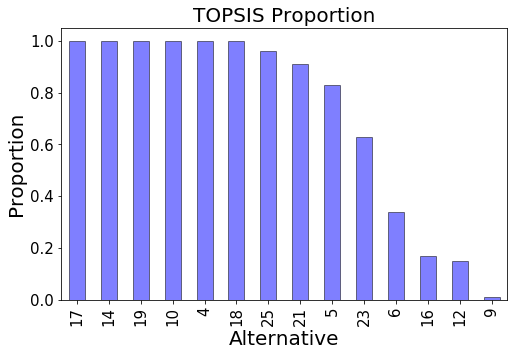

In [56]:
top_suppliers_topsis = robust_ranking(supplier_data,
                               columns_to_normalize,
                               weights,
                               'Supplier',
                               num_perturbations = 100,
                               perturbation_width = 0.15,
                               score_type = 'topsis',
                               top_values = 10,
                               include_plot = True)

The following code block prints the `DataFrame` object that was returned by the previous function call.

[Back to Table of Contents](#Table_of_Contents)<br>

In [57]:
top_suppliers_topsis

,Alternative,TOPSIS Count,TOPSIS Proportion
0,17,100,1.00
1,14,100,1.00
2,19,100,1.00
4,10,100,1.00
5,4,100,1.00
7,18,100,1.00
3,25,96,0.96
8,21,91,0.91
6,5,83,0.83
11,23,63,0.63


The following code block shows how we can use the `functools` package, along with pandas, to combine `DataFrame` objects created by running the `robust_ranking` function with TOPSIS, weighted sum, and weighted product scoring methods. We replace all mising values in the resulting object (`df_final`) with 0.

[Back to Table of Contents](#Table_of_Contents)<br>

In [58]:
top_suppliers_topsis = robust_ranking(supplier_data,
                               columns_to_normalize,
                               weights,
                               'Supplier',
                               num_perturbations = 100,
                               perturbation_width = 0.15,
                               score_type = 'topsis',
                               top_values = 10,
                               include_plot = False)

top_suppliers_WS = robust_ranking(supplier_data,
                               columns_to_normalize,
                               weights,
                               'Supplier',
                               num_perturbations = 100,
                               perturbation_width = 0.15,
                               score_type = 'weighted_sum',
                               top_values = 10,
                               include_plot = False)

top_suppliers_WP = robust_ranking(supplier_data,
                               columns_to_normalize,
                               weights,
                               'Supplier',
                               num_perturbations = 100,
                               perturbation_width = 0.15,
                               score_type = 'weighted_product',
                               top_values = 10,
                               include_plot = False)


dfs = [top_suppliers_topsis, top_suppliers_WP, top_suppliers_WS]

from functools import reduce

df_final = reduce(lambda left, right: pd.merge(left, right, on='Alternative', how='outer'), dfs)

df_final = df_final.fillna(0)

df_final

,Alternative,TOPSIS Count,TOPSIS Proportion,Weighted Product Count,Weighted Product Proportion,Weighted Sum Count,Weighted Sum Proportion
0,17,100.00,1.00,100.00,1.00,100.00,1.00
1,14,100.00,1.00,100.00,1.00,100.00,1.00
2,19,100.00,1.00,100.00,1.00,100.00,1.00
3,10,100.00,1.00,96.00,0.96,95.00,0.95
4,4,100.00,1.00,100.00,1.00,100.00,1.00
5,18,100.00,1.00,100.00,1.00,100.00,1.00
6,25,96.00,0.96,18.00,0.18,9.00,0.09
7,21,91.00,0.91,100.00,1.00,100.00,1.00
8,5,83.00,0.83,100.00,1.00,100.00,1.00
9,23,63.00,0.63,95.00,0.95,11.00,0.11


The following code block prints the `df_final` object to illustrate how the rankings vary for suppliers that were included in the top 10 highest scoring suppliers for one of the methods.

[Back to Table of Contents](#Table_of_Contents)<br>

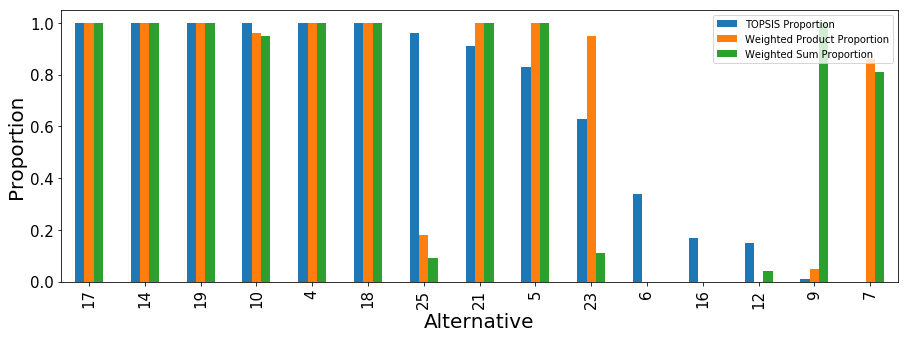

In [59]:
fig, ax = plt.subplots(1,1,figsize = (15,5))


df_final.plot(x="Alternative",
              y=['TOPSIS Proportion', 
                 'Weighted Product Proportion', 
                 'Weighted Sum Proportion'], 
              ax = ax,
              kind="bar")

ax.set_xlabel('Alternative',fontsize = 20)
ax.set_ylabel('Proportion',fontsize = 20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

plt.show()

The following code block repeats the previous analysis, but allows the user to change the perturbation range and see the change in the ranking results.

[Back to Table of Contents](#Table_of_Contents)<br>

In [60]:
perturbation_width_vals = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25]
num_perturbation_vals = [10, 25, 100]
top_vals_list = [3, 5, 10]

@interact(perturbation_width = perturbation_width_vals,
          num_perturbations = num_perturbation_vals,
          top_vals = top_vals_list)

def interactive_plot(perturbation_width = perturbation_width_vals[0],
                     num_perturbations = num_perturbation_vals[0],
                     top_vals = top_vals_list[0]):
    
    top_suppliers_topsis = robust_ranking(supplier_data,
                                   columns_to_normalize,
                                   weights,
                                   'Supplier',
                                   num_perturbations = num_perturbations,
                                   perturbation_width = perturbation_width,
                                   score_type = 'topsis',
                                   top_values = top_vals,
                                   include_plot = False)

    top_suppliers_WS = robust_ranking(supplier_data,
                                   columns_to_normalize,
                                   weights,
                                   'Supplier',
                                   num_perturbations = num_perturbations,
                                   perturbation_width = perturbation_width,
                                   score_type = 'weighted_sum',
                                   top_values = top_vals,
                                   include_plot = False)

    top_suppliers_WP = robust_ranking(supplier_data,
                                   columns_to_normalize,
                                   weights,
                                   'Supplier',
                                   num_perturbations = num_perturbations,
                                   perturbation_width = perturbation_width,
                                   score_type = 'weighted_product',
                                   top_values = top_vals,
                                   include_plot = False)


    dfs = [top_suppliers_topsis, top_suppliers_WP, top_suppliers_WS]

    from functools import reduce

    df_final = reduce(lambda left, right: pd.merge(left, right, on='Alternative', how='outer'), dfs)

    df_final = df_final.fillna(0)
    
    fig, ax = plt.subplots(1,1,figsize = (15,5))


    df_final.plot(x="Alternative",
                  y=['TOPSIS Proportion', 
                     'Weighted Product Proportion', 
                     'Weighted Sum Proportion'], 
                  ax = ax,
                  kind="bar")

    ax.set_xlabel('Alternative',fontsize = 20)
    ax.set_ylabel('Proportion',fontsize = 20)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    plt.show()


interactive(children=(Dropdown(description='perturbation_width', options=(0.01, 0.05, 0.1, 0.15, 0.2, 0.25), v…